Prima montiamo Google Drive.

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
from pathlib import Path

directory = '/content/drive/My Drive/Progetto_SD/data'
path = Path(directory)

Contiamo quante immagini ci sono.

In [13]:
image_count = len(list(path.glob('*/*.jpg')))
print(image_count)

5387


Proviamo a vedere quante immagini di pallavolo ci sono.

In [14]:
import PIL

volleyball = list(path.glob('volleyball/*'))
len(volleyball)
#PIL.Image.open(str(volleyball[1]))

713

Faccio il resize di tutte le immagini

In [15]:
import tensorflow as tf

batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6066 files belonging to 9 classes.
Using 4853 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6066 files belonging to 9 classes.
Using 1213 files for validation.


Vediamo i nomi delle classi.

In [17]:
class_names = train_ds.class_names
print(class_names)

['basketball', 'boxing', 'fencing', 'football', 'formula1', 'motogp', 'swimming', 'tennis', 'volleyball']


Visualizziamo i dati

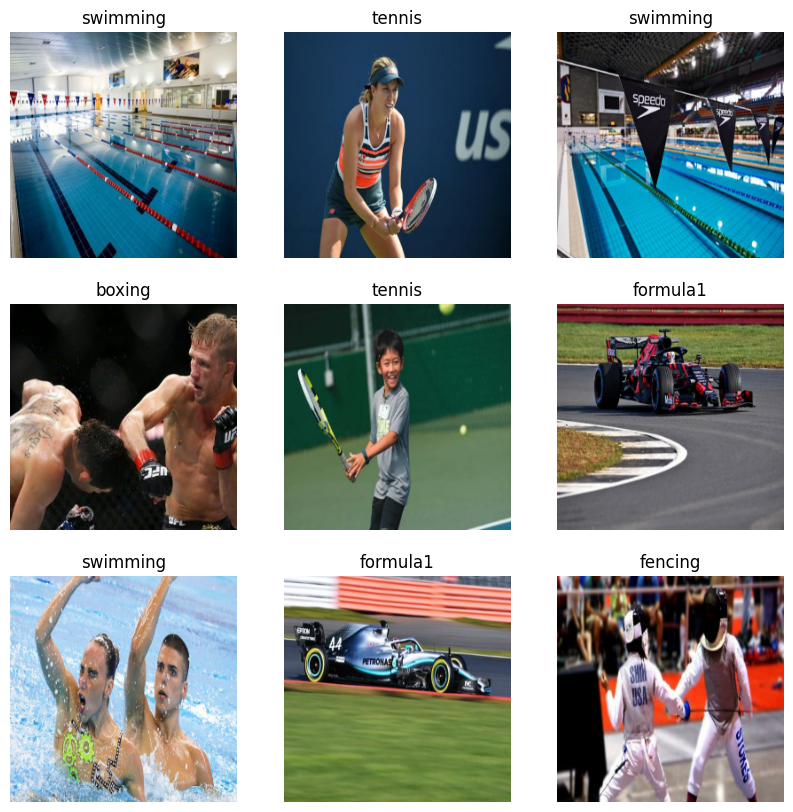

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creo il livello per definire la scala dei colori

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [21]:
normalization_layer = layers.Rescaling(1./255)

In [22]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [23]:
from tensorflow.keras.models import Sequential

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
152/152 [==============================] - 207s 1s/step - loss: 1.4434 - accuracy: 0.4958 - val_loss: 1.1851 - val_accuracy: 0.5903
Epoch 2/10
152/152 [==============================] - 6s 38ms/step - loss: 0.9628 - accuracy: 0.6785 - val_loss: 1.0243 - val_accuracy: 0.6480
Epoch 3/10
152/152 [==============================] - 6s 38ms/step - loss: 0.6024 - accuracy: 0.8065 - val_loss: 0.9973 - val_accuracy: 0.6678
Epoch 4/10
152/152 [==============================] - 6s 38ms/step - loss: 0.3158 - accuracy: 0.9005 - val_loss: 1.1726 - val_accuracy: 0.6941
Epoch 5/10
152/152 [==============================] - 6s 38ms/step - loss: 0.1618 - accuracy: 0.9520 - val_loss: 1.2491 - val_accuracy: 0.6694
Epoch 6/10
152/152 [==============================] - 6s 38ms/step - loss: 0.0854 - accuracy: 0.9757 - val_loss: 1.4911 - val_accuracy: 0.6636
Epoch 7/10
152/152 [==============================] - 6s 38ms/step - loss: 0.0520 - accuracy: 0.9856 - val_loss: 1.6213 - val_accuracy: 0.6711

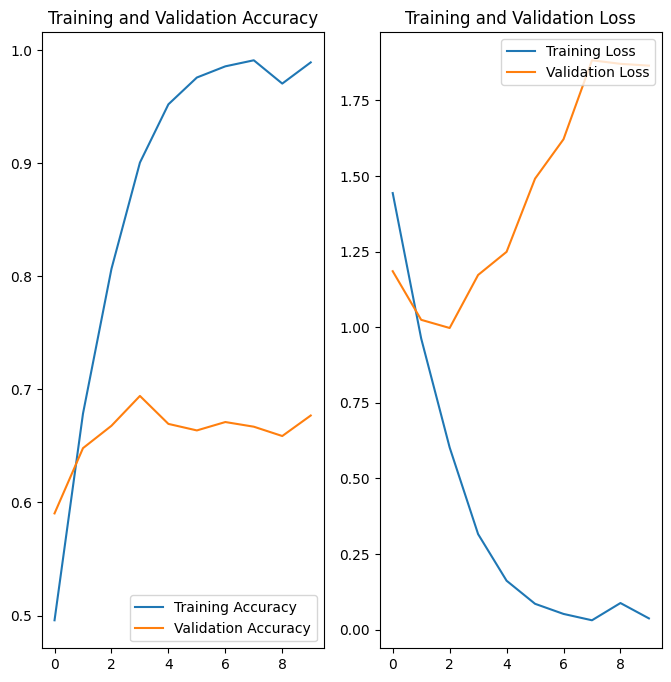

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Proviamo a predire una nuova immagine. La label deve essere nuoto.

In [27]:
nuoto_path = "/content/drive/My Drive/Progetto_SD/data/nuoto.jpg"

from tensorflow.keras.preprocessing import image

# Carica l'immagine
img = image.load_img(nuoto_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Crea un batch

# Effettua le predizioni
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Stampa il risultato
print("Questa immagine appartiene più probabilmente a {} con una confidenza del {:.2f} percento."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 274ms/step
Questa immagine appartiene più probabilmente a swimming con una confidenza del 99.95 percento.


In [28]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)